In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from utils.metrics import UnbiasedExponentialMovingAverage as uema

In [2]:
with open(f"./models/E13_every_size_1day_trace5_delta.pickle", "rb") as f:
    GP_model = pickle.load(f)

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [6]:
input = np.vstack([np.array([100, 0, 1, 0, 0, 0, 0])])
data = GP_model.sample_output(input, N=100)
np.percentile(data, 85)

101.47567586668785

In [4]:
GP_model.predict_mean_std(input)

(Array([59.52288752], dtype=float64), Array([39.78507188], dtype=float64))

In [3]:
import polars as pl

df = pl.read_parquet("./GP_data/cleaned_offline_dataset_daily_continuous.parquet")

df = df.with_columns(
    pl.col("clean_area")
    .shift(-1)
    .over("experiment", "zone", "plant_id")
    .alias("next_clean_area"),
)
# remove rows with truncated = true
df = df.filter(pl.col("truncated") == False)
# remove rows with null next_mean_clean_area
df = df.filter(pl.col("next_clean_area").is_not_null())

In [10]:
val_df = df.filter((pl.col("zone") == 3) & (pl.col("experiment") == 13))

In [11]:
val_df = val_df.with_columns(
    pl.col("clean_area")
    .mean()
    .over("experiment", "zone", "time")
    .alias("mean_clean_area"),
)
val_df = val_df.with_columns(
    pl.col("next_clean_area")
    .mean()
    .over("experiment", "zone", "time")
    .alias("mean_next_clean_area"),
)
val_df = val_df.filter(pl.col("plant_id") == 0)

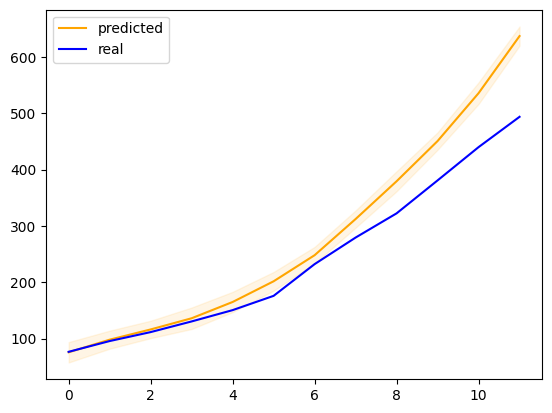

In [12]:
fig, ax = plt.subplots()

input_data = np.vstack(
    list(
        zip(
            val_df["mean_clean_area"].to_list(),
            val_df["red_coef"].to_list(),
            val_df["white_coef"].to_list(),
            val_df["blue_coef"].to_list(),
            val_df["red_coef_trace_0.5"].to_list(),
            val_df["white_coef_trace_0.5"].to_list(),
            val_df["blue_coef_trace_0.5"].to_list(),
            val_df["red_coef_trace_0.7"].to_list(),
            val_df["white_coef_trace_0.7"].to_list(),
            val_df["blue_coef_trace_0.7"].to_list(),
            val_df["red_coef_trace_0.9"].to_list(),
            val_df["white_coef_trace_0.9"].to_list(),
            val_df["blue_coef_trace_0.9"].to_list(),
        )
    )
)
output_data = np.vstack(val_df["mean_next_clean_area"].to_list())
MEAN = []
STD = []
current_area = input_data[0][0]
for i in range(len(output_data)):
    input = np.hstack([[current_area], input_data[i][1:]])
    predictive_mean, predictive_std = GP_model.predict_mean_std(np.vstack([input]))
    MEAN.append(current_area + predictive_mean[0])
    STD.append(predictive_std[0])
    current_area += predictive_mean[0]

MEAN = np.array(MEAN)
STD = np.array(STD)

ax.plot(MEAN, color="orange", label="predicted")
ax.fill_between(
    np.arange(len(output_data)),
    MEAN - STD,
    MEAN + STD,
    alpha=0.1,
    color="orange",
)
ax.plot(output_data, color="blue", label="real")
ax.legend()

In [ ]:
actions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
test_area = np.linspace(0, 500, 100)
tests = [
    np.vstack([[area] + actions[i] + [0.33, 0.33, 0.33] for area in test_area])
    for i in range(3)
]
Mean = []
Std = []
for i in range(3):
    predictive_mean, predictive_std = GP_model.predict_mean_std(tests[i])
    Mean.append(predictive_mean)
    Std.append(predictive_std)

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


/tmp/ipykernel_2086/2951416745.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


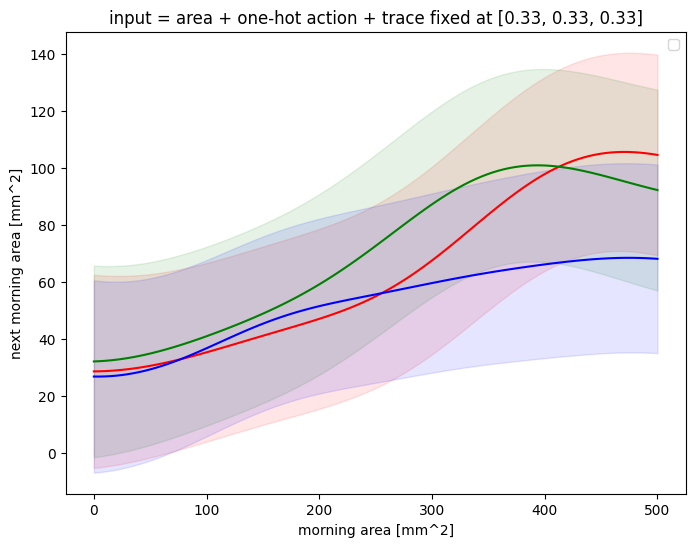

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
COLORS = ["r", "g", "b"]
for i in range(3):
    ax.plot(test_area, Mean[i], color=COLORS[i])
    ax.fill_between(
        test_area.squeeze(),
        Mean[i] - 1 * Std[i],
        Mean[i] + 1 * Std[i],
        alpha=0.1,
        color=COLORS[i],
    )
ax.set_xlabel("morning area [mm^2]")
ax.set_ylabel("next morning area [mm^2]")
ax.set_title(f"input = area + one-hot action + trace fixed at [0.33, 0.33, 0.33]")
# ax.set_title(f"input = area + one-hot action ")
ax.legend()
# ax.set_xlim([100, 1000])
# ax.set_ylim([100., 750])

Text(0, 0.5, 'morning area [mm^2]')

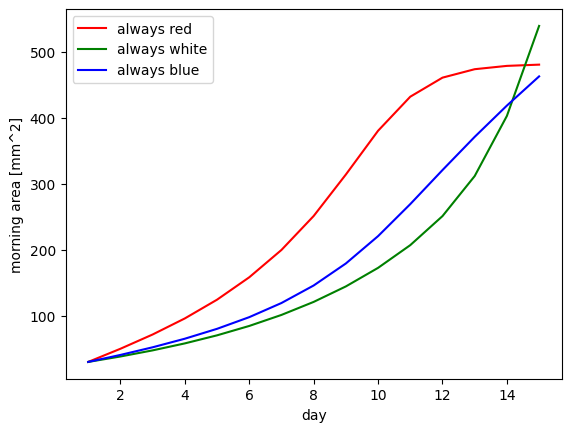

In [10]:
policies = [
    [np.squeeze(np.eye(1, 3, i)).tolist() for day in range(14)] for i in range(3)
]
COLORS = ["r", "g", "b"]
LABELS = ["always red", "always white", "always blue"]
AREA_CURVES = []
for i, policy in enumerate(policies):
    area = 30
    area_record = [area]
    trace = [uema(alpha=0.5), uema(alpha=0.5), uema(alpha=0.5)]
    for lighting in policy:
        for j in range(3):
            trace[j].update(lighting[j])
        input = np.array(
            [area_record[-1]]
            + lighting
            + [
                trace[0].compute().item(),
                trace[1].compute().item(),
                trace[2].compute().item(),
            ]
        ).reshape(1, -1)
        predictive_mean, predictive_std = GP_model.predict_mean_std(input)
        area_record.append(predictive_mean[0])
    plt.plot(np.arange(1, 16), area_record, color=COLORS[i], label=LABELS[i])
plt.legend()
plt.xlabel("day")
plt.ylabel("morning area [mm^2]")

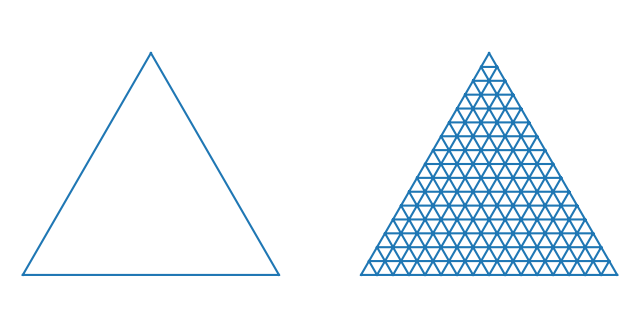

In [4]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
trimesh.set_mask

plt.figure(figsize=(8, 4))
for i, mesh in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i + 1)
    plt.triplot(mesh)
    plt.axis("off")
    plt.axis("equal")

In [5]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))


def xy2bc(xy, tol=1.0e-4):
    """Converts 2D Cartesian coordinates to barycentric."""
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)


coord = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
len(coord)

153

In [6]:
# Fix input area, sample lighting using the triangle grid above
test_area = [200, 350, 550]
tests = [
    np.vstack(
        [[test_area[i]] + lighting.tolist() + [0.33, 0.33, 0.33] for lighting in coord]
    )
    for i in range(3)
]
Mean = []
Std = []
for i in range(3):
    predictive_mean, predictive_std = GP_model.predict_mean_std(tests[i])
    Mean.append(predictive_mean)
    Std.append(predictive_std)

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


/tmp/ipykernel_181141/659236775.py:4: UserWarning: The following kwargs were not used by contour: 'nlevels'
  plt.tricontourf(trimesh, Mean[i], nlevels=200, cmap="Purples")


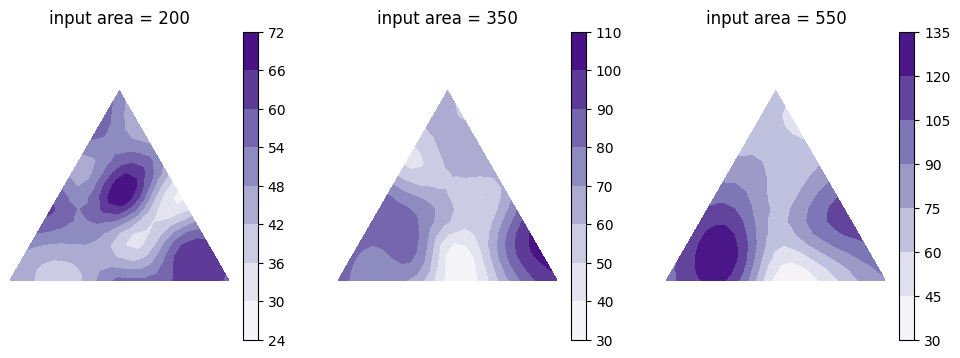

In [7]:
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.tricontourf(trimesh, Mean[i], nlevels=200, cmap="Purples")
    plt.colorbar()
    plt.title(f"input area = {test_area[i]}")
    plt.axis("equal")
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis("off")